# Easy21 - Control

Github URL: https://github.com/vinicustod/easy21_control

### Game Rules
- The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
- At the start of the game both the player and the dealer draw one black card (fully observed).
- Each turn the player may either stick or hit.
- If the player hits then she draws another card from the deck.
- If the player sticks she receives no further cards.
- The values of the player’s cards are added (black cards) or subtracted (red cards).
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1).
- If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.



##### Implementation of Easy21 simulator
You should write an environment that implements the game Easy21. Specifically, write a function, named STEP, which takes as **input a state s** (dealer’s first card 1–10 and the player’s sum 1–21), **and an action a** (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for prediction and for control (in the next part of this EP) and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.



First of all we will define the environment

In [1]:
import random
import numpy as np
import math
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

HIT = 0
STICK = 1
RED = 'red'
BLACK = 'black'
TERMINAL_STATE = "end"


class State(object):
    def __init__(self, dealer=random.randint(1, 10), player=random.randint(1, 10)):
        self.dealer = dealer
        self.player = player

class Easy21Env:

    def __init__(self, seed=-1):
        if seed != -1:
            random.seed(seed)
#         self.policy = policy

    @staticmethod
    def get_card():
        return random.randint(1, 10)

    @staticmethod
    def get_color():
        return RED if random.random() < 1 / 3 else BLACK

    def draw(self, state):
        card = self.get_card()
        if self.get_color() == BLACK:
            state += card
        else:
            state -= card

        return state

    def step(self, state, action):
        if action == HIT:
            player = self.draw(state.player)
            if player < 1 or player > 21:
                return TERMINAL_STATE, -1.0
            else:
                return State(dealer=state.dealer, player=player), 0.0
        else:
            dealer = state.dealer
            while dealer < 17:
                dealer = self.draw(dealer)
                if dealer < 1 or dealer > 21:
                    return TERMINAL_STATE, 1.0

            if dealer > state.player:
                return TERMINAL_STATE, -1.0
            elif dealer == state.player:
                return TERMINAL_STATE, 0.0
            else:
                return TERMINAL_STATE, 1.0

And now the utility methods to plot graphs.

In [7]:
def sub_plot(values, name, names):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, to_plot in enumerate(values):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        x = range(10)
        y = range(21)
        X, Y = np.meshgrid(y, x)
        
        value = to_plot
        ax.plot_wireframe(Y+1, X+1, value[1:, 1:])
        ax.set_xlabel('Dealer Cards')
        ax.set_ylabel('Player Card')
        ax.set_zlabel(r'$v_{\pi}$')
        ax.title.set_text(names[i])
    fig.suptitle(name)
    
    plt.show()


def plot_v_function(value, name):
    fig = plt.figure()
    sliced_value = value[1:, 1:]
    plt.imshow(sliced_value, cmap='jet')
    plt.ylabel('Dealer card')
    plt.xlabel('Player card')
    plt.ylim(ymin=1)
    plt.xlim(xmin=1)
    plt.xticks(np.arange(21)+1)
    plt.yticks(np.arange(10)+1)
    plt.gca().invert_yaxis()
    fig.suptitle(name)
    plt.colorbar()
    
    plt.show()
    
def plot_wire(value, name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = range(10)
    y = range(21)
    X, Y = np.meshgrid(y, x)
    ax.plot_wireframe(Y+1, X+1, value[1:, 1:])
    ax.set_xlabel('Dealer Cards')
    ax.set_ylabel('Player Card')
    ax.set_zlabel(r'$v_{\pi}$')
    fig.suptitle(name)
    
    plt.show()
    

Since we will be plotting V, the function below given Q returns V.

In [8]:
def get_V(q):
    v = np.zeros((11,22))
    
    for i in range(11):
        for j in range(22):
            v[i, j] = q[np.argmax(q[:, i, j]), i, j]

    return v

## Monte Carlo

In [9]:
easy21env = Easy21Env(seed=20)

def monte_carlo_prediction(q=np.zeros((2,11, 22)),n=np.zeros((2,11, 22)), t_episodes=1000):
    
    for i in range(t_episodes):
        state = State()
        state.dealer = random.randint(1,10)
        state.player = random.randint(1,10)

        episode = []
        g = 0
        while state != TERMINAL_STATE:
            e = 100 / (100 + (np.sum(n[:, state.dealer, state.player])))
            action = None
            if random.random() > e:
                action = np.argmax(q[:, state.dealer, state.player])
            else:
                action = random.randint(0,1)

            new_state, reward = easy21env.step(state, action)
            episode.append((state, action, reward))

            g += reward
            state=new_state
            
        for state, action, reward in episode:
            n[action, state.dealer, state.player] += 1
            a = 1 / n[action, state.dealer, state.player]
            q[action, state.dealer, state.player] += a * (g - q[action, state.dealer, state.player])

    return q, n

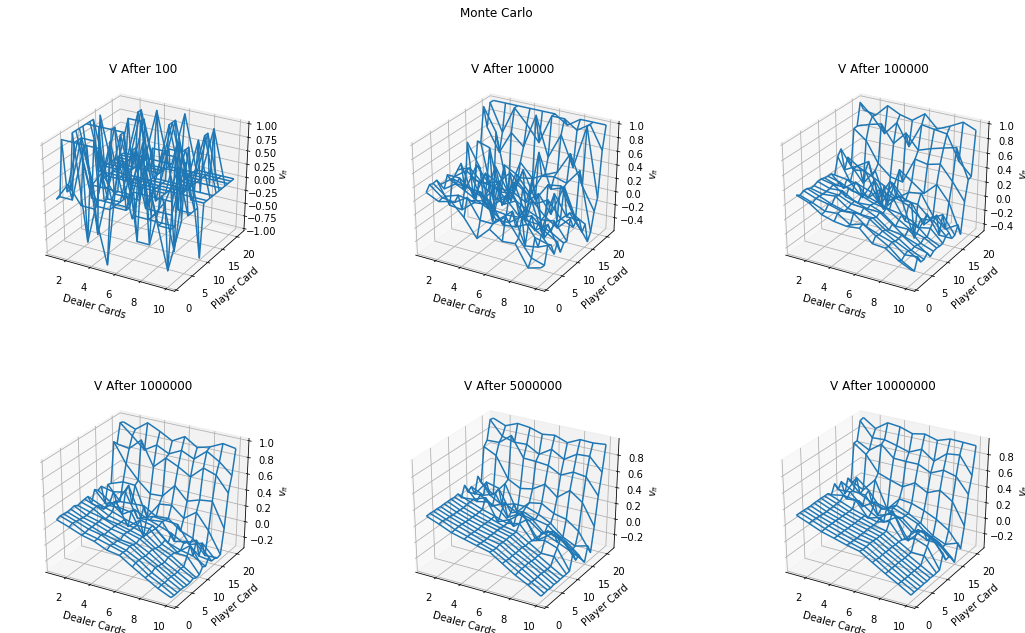

In [10]:
random.seed(20)

v_mc = []
v_names = []
q = np.zeros((2,11,22))
n = np.zeros((2,11,22))

sum_epi = 0
for i in [100, 9900, 90000, 900000, 4000000, 5000000]:
    q, n = monte_carlo_prediction(q=q, n=n, t_episodes=i)
    v_mc.append(get_V(q))
    sum_epi += i
    v_names.append("V After "+str(sum_epi))

sub_plot(v_mc, "Monte Carlo", v_names)

In the graphs above we can see, how V progresses throughout the episodes, and that after a hundred thousand episodes V already have a defined shape. Which starts to be refined as the number of episodes increases.

## TD($\lambda$)

In [11]:
def td(q=np.zeros((2, 11, 22)), n=np.zeros((2, 11, 22)), t_episodes=1000, scaling=0):
    for i in range(t_episodes):
        state = State()
        state.dealer = random.randint(1,10)
        state.player = random.randint(1,10)

        episode = []
        while state != TERMINAL_STATE:
            e = 100 / (100 + (np.sum(n[:, state.dealer, state.player])))
            action = None
            if random.random() > e:
                action = np.argmax(q[:, state.dealer, state.player])
            else:
                action = random.randint(0,1)

            new_state, reward = easy21env.step(state, action)
            episode.append((state, action, reward))
            state=new_state
            
        for j in range(len(episode)):
            state, action, reward = episode[j]
            reward_sum = 0
            g_total = 0
            maxstep = (len(episode) - j)

            for next_index in range(maxstep):
                lookahead_index = next_index + j
                lookahead_state, lookahead_action, lookahead_reward = episode[lookahead_index]

                if lookahead_index < len(episode)-1: 
                    next_state, next_action, _ = episode[lookahead_index+1]
                    next_state_value = q[next_action, next_state.dealer, next_state.player]
                else:
                    next_state_value = 0
    
                reward_sum = reward_sum + lookahead_reward
                g = reward_sum + next_state_value

                if (maxstep - 1) == next_index:
                    g_total += math.pow(scaling, next_index) * g
                else:
                    g_total += (1.0 - scaling) * math.pow(scaling, next_index) * g

            n[action, state.dealer, state.player] += 1
            a = 1.0 / n[action, state.dealer, state.player]
            q[action, state.dealer, state.player] += a * (g_total - q[action, state.dealer, state.player])

    return q, n

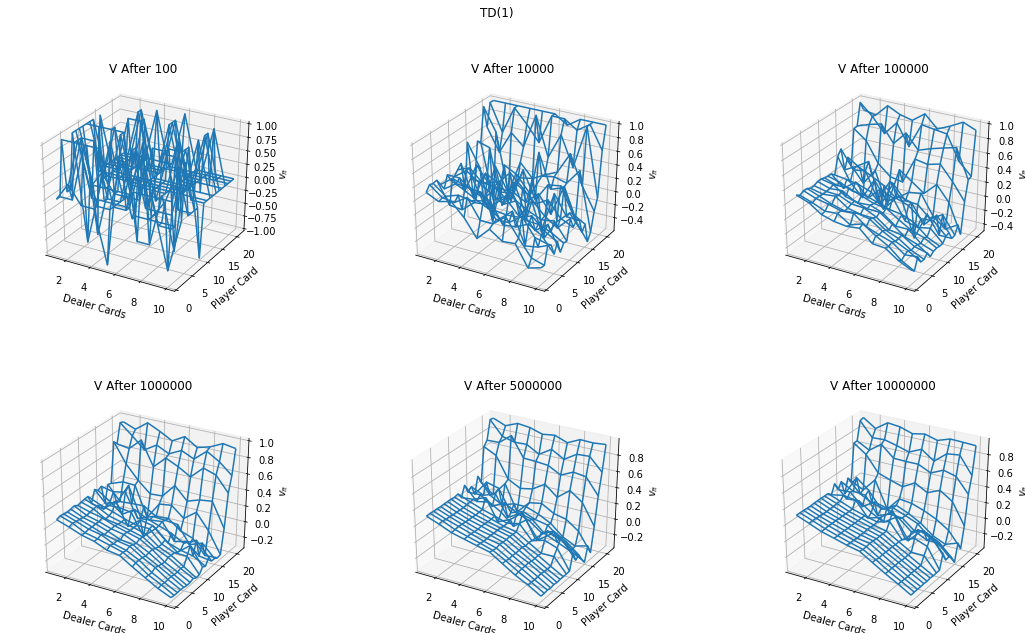

In [14]:
random.seed(20)

v_td = []
v_td_names = []
q_td = np.zeros((2,11,22))
n_td = np.zeros((2,11,22))

sum_epi = 0
for i in [100, 9900, 90000, 900000, 4000000, 5000000]:
    q_td, n_td = td(q=q_td, n=n_td, t_episodes=i, scaling=1)
    v_td.append(get_V(q_td))
    sum_epi += i
    v_td_names.append("V After "+str(sum_epi))

sub_plot(v_mc, "TD(1)", v_names)

The same thing happens here while using the TD($\lambda \rightarrow 1$), after a hundred thousand episodes the shape is already defined and improves slowly until we reach 10 million episodes.

## Mean Square Error against episodes

<Figure size 432x288 with 0 Axes>

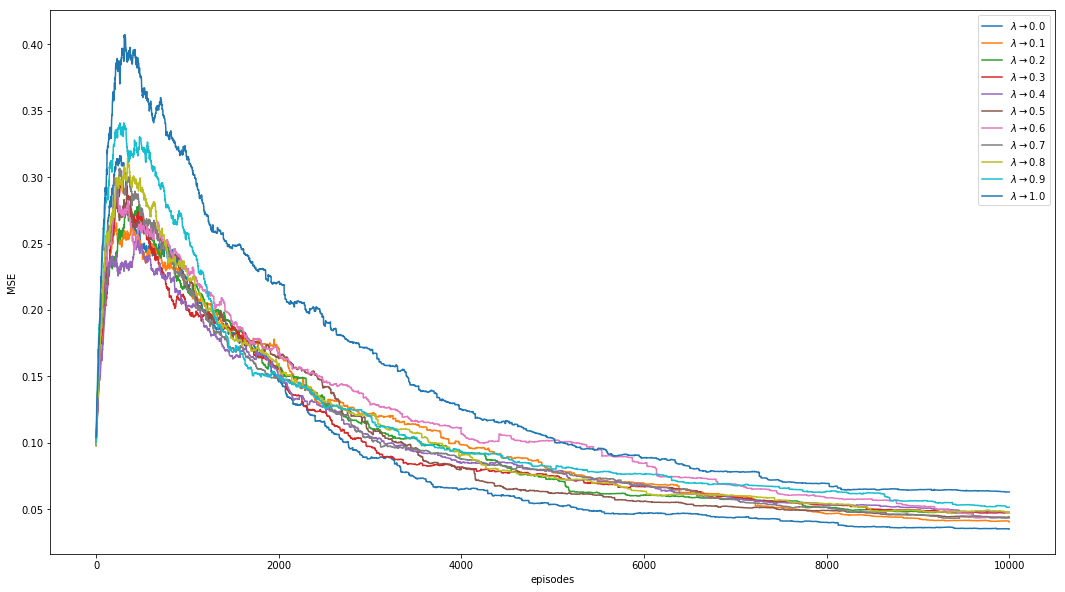

In [31]:
msqe = np.zeros((11,int(10000)))
random.seed(20)

plt.clf()    
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(18)


for i in range(11):
    td_value = np.zeros((2,11,22))
    td_counter = np.zeros((2,11,22))
    for j in range(10000):
        td_value, td_counter = td(q=td_value, n=td_counter, t_episodes=1, scaling=i*0.1)
        msqe[i, int(j)] = np.sum(np.square(q - td_value)) / (2*11*22)
    plt.plot(np.arange(10000), msqe[i],label=r'$\lambda \rightarrow {:.1f}$'.format(i*0.1))

plt.ylabel("MSE")
plt.xlabel("episodes")
plt.legend()

plt.show()

Above we have the Mean square error for $\lambda$ varying from 0 to 1, with increase rate of 0.1. This graph uses the V* of Monte Carlo after 10 million episodes. As we can see after ten thousand episodes the error for almost all $\lambda$'s are close to 0.05

## Mean Square Error against $\lambda$

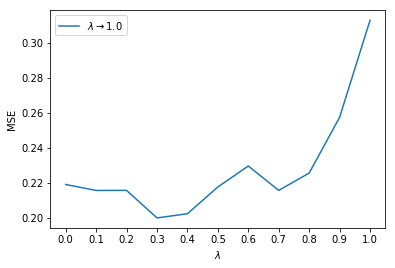

In [45]:
msq_lambda = []
for i in range(11):
    msq_lambda.append(msqe[i, 999])
    
plt.clf()    
plt.plot(np.arange(11)* 0.1, msq_lambda,label=r'$\lambda \rightarrow {:.1f}$'.format(1))
plt.xticks(np.arange(11) * 0.1)
plt.ylabel("MSE")
plt.xlabel("$\lambda$")
plt.legend()
plt.show()



The graph above shows the mean square error for $\lambda$'s varying from 0 to 1 after a thousand episode. One important behaviour to notice is that we have a higher error for $\lambda \rightarrow 1$, but this value will converge to 0, since TD($\lambda \rightarrow 1$) is equivalent to Monte Carlo, below we can see that (both of then after 10 billion episodes).

In [46]:
print(np.sum(np.square(q - q_td)) / (2*11*22))

0.0


### What are the pros and cons of bootstrapping in Easy21?

The cons of using bootstrapping is the bias introduce by the initial values and because all non terminal states have reward 0 will be doing some unecessary updates, but after some episodes, each state will have a value available to contribute to convergence of that state.

### Would you expect bootstrapping to help more in blackjack or Easy21? Why?

I expect, bootstrapping to help more on the Blackjack, since the episodes are shorter and do not repeat. Which will allow better estimates for the states that were already visited.